<h3>Importing Libraries</h3>

In [2]:
import torch
import numpy as np
from tqdm import tqdm
import numpy as np
import pandas as pd

<h3> Device Selection for Model Training</h3>

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


<h3>Data Preprocessing : Image Resizing and Transformation </h3>

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

<h3>Loading Testing and Training Images from the Folder using Kaggle ASL Data Set</h3>

In [5]:
# Load dataset
train_dataset_path = r"/Users/prabhanshu/Desktop/👨🏻‍💻/Projects ML/SignVision/Final_Project/asl_alphabet_train"
test_dataset_path = r"/Users/prabhanshu/Desktop/👨🏻‍💻/Projects ML/SignVision/Final_Project/asl_alphabet_test1"
train_ds = ImageFolder(root=train_dataset_path, transform=transform)
test_ds = ImageFolder(root=test_dataset_path, transform=transform)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# View class labels
class_names = train_ds.classes
print(f"Classes: {class_names}")


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


In [6]:
print(f"Number of Classes : {len(class_names)}")
print(f"Number of Images is Testing Dataset : {len(train_ds)}")
print(f"Number of Images is Testing Dataset : {len(test_ds)}")
number_of_images_per_class_train = train_ds.targets.count(0)
print(f"Number of images per class in Training Set: {number_of_images_per_class_train}")
number_of_images_per_class_test = test_ds.targets.count(0)
print(f"Number of images per class in Test Set: {number_of_images_per_class_test}")

Number of Classes : 28
Number of Images is Testing Dataset : 84000
Number of Images is Testing Dataset : 28
Number of images per class in Training Set: 3000
Number of images per class in Test Set: 1


<h3>Defining the CNN Model using Pytorch</h3>

In [7]:
import torch.nn as nn

class ASLClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ASLClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input: (3, 64, 64)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # input: (3, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # output: (32, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                            # output: (64, 16, 16)
            nn.Flatten(),
            nn.Linear(64*16*16, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = ASLClassifier(num_classes=len(class_names)).to(device)
print(model)


ASLClassifier(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16384, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=28, bias=True)
  )
)


<h3>Defining Loss Function and Optimizer</h3>

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


<h3>Training the Model</h3>

In [9]:
epochs = 10
train_loss_history = []
test_loss_history = []
epoch_count = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    running_test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss = loss_fn(outputs, labels)
            running_test_loss += test_loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)

    # Record epoch
    epoch_count.append(epoch + 1)

    # Print
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")


Epoch 1/10 [Training]: 100%|██████████| 1313/1313 [09:03<00:00,  2.41it/s]


Epoch [1/10] | Train Loss: 0.7731 | Test Loss: 0.0124


Epoch 2/10 [Training]: 100%|██████████| 1313/1313 [19:01<00:00,  1.15it/s]   


Epoch [2/10] | Train Loss: 0.1098 | Test Loss: 0.0456


Epoch 3/10 [Training]: 100%|██████████| 1313/1313 [08:56<00:00,  2.45it/s]


Epoch [3/10] | Train Loss: 0.0542 | Test Loss: 0.0116


Epoch 4/10 [Training]: 100%|██████████| 1313/1313 [09:03<00:00,  2.42it/s]


Epoch [4/10] | Train Loss: 0.0395 | Test Loss: 0.0006


Epoch 5/10 [Training]: 100%|██████████| 1313/1313 [08:59<00:00,  2.43it/s]


Epoch [5/10] | Train Loss: 0.0302 | Test Loss: 0.0002


Epoch 6/10 [Training]: 100%|██████████| 1313/1313 [08:59<00:00,  2.43it/s]


Epoch [6/10] | Train Loss: 0.0265 | Test Loss: 0.0017


Epoch 7/10 [Training]: 100%|██████████| 1313/1313 [13:20<00:00,  1.64it/s]  


Epoch [7/10] | Train Loss: 0.0223 | Test Loss: 0.0000


Epoch 8/10 [Training]: 100%|██████████| 1313/1313 [08:56<00:00,  2.45it/s]


Epoch [8/10] | Train Loss: 0.0166 | Test Loss: 0.0000


Epoch 9/10 [Training]: 100%|██████████| 1313/1313 [08:48<00:00,  2.48it/s]


Epoch [9/10] | Train Loss: 0.0169 | Test Loss: 0.0000


Epoch 10/10 [Training]: 100%|██████████| 1313/1313 [08:53<00:00,  2.46it/s]

Epoch [10/10] | Train Loss: 0.0128 | Test Loss: 0.0422


<h3>Evaluating the trained Model using Test Dataset</h3>

In [10]:
def evaluate(model, data_loader, class_names, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    num_classes = len(class_names)

    # Per-class TP/FP/FN
    TP_per_class = np.zeros(num_classes, dtype=int)
    FP_per_class = np.zeros(num_classes, dtype=int)
    FN_per_class = np.zeros(num_classes, dtype=int)

    for c in range(num_classes):
        TP = np.sum((y_pred == c) & (y_true == c))
        FP = np.sum((y_pred == c) & (y_true != c))
        FN = np.sum((y_pred != c) & (y_true == c))

        TP_per_class[c] = TP
        FP_per_class[c] = FP
        FN_per_class[c] = FN

    # Precision, Recall, F1
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for c in range(num_classes):
        TP = TP_per_class[c]
        FP = FP_per_class[c]
        FN = FN_per_class[c]

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_per_class.append(f1)

    # Macro-averaged
    precision_macro = np.mean(precision_per_class)
    recall_macro = np.mean(recall_per_class)
    f1_macro = np.mean(f1_per_class)

    # Accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall:    {recall_macro:.4f}")
    print(f"Macro F1 Score:  {f1_macro:.4f}")


In [11]:
print("\n--- Training Set Evaluation ---")
evaluate(model, train_loader, class_names, device)

print("\n--- Test Set Evaluation ---")
evaluate(model, test_loader, class_names, device)



--- Training Set Evaluation ---
Accuracy: 0.9964
Macro Precision: 0.9965
Macro Recall:    0.9964
Macro F1 Score:  0.9964

--- Test Set Evaluation ---
Accuracy: 0.9643
Macro Precision: 0.9464
Macro Recall:    0.9643
Macro F1 Score:  0.9524


<h3>PLotting Confusion Matrix</h3>

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

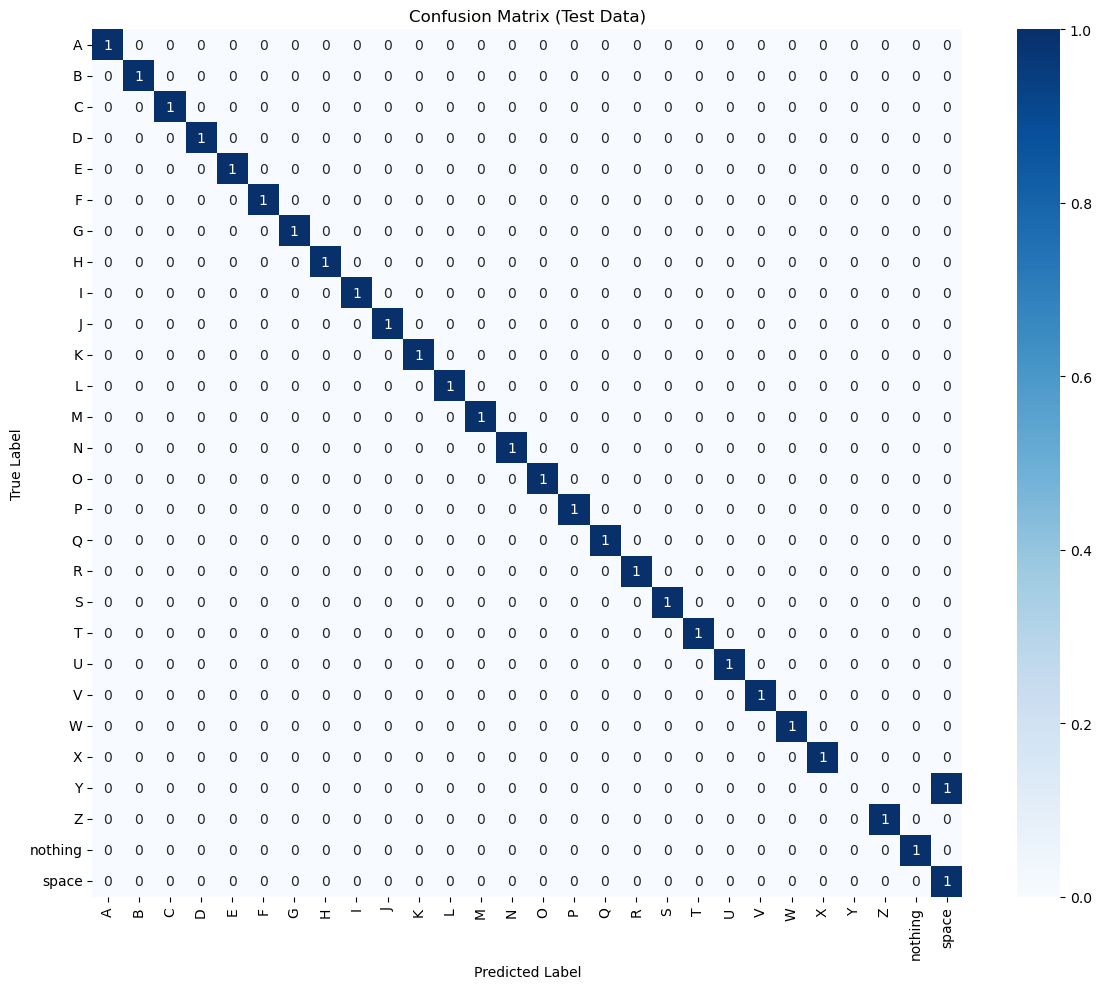

Expected Labels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Predicted Labels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 25, 26, 27]


In [14]:
# Run predictions and collect labels
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion(y_true, y_pred, class_names, title="Confusion Matrix (Test Data)")
print(f"Expected Labels : {y_true}")
print(f"Predicted Labels : {y_pred}")
